# Sentiment Analysis 
# Amazon Musical Instruments Reviews


Problem statement
- This is the Problem Statement to classify the customer comments. This would be helpful for the organization to understand Customer feedbacks.

Objectives of Project
- Reviews Preprocessing and Cleaning
- Story Generation and Visualization from reviews
- Extracting Features from Cleaned reviews
- Model Building: Sentiment Analysis

#  1 ) Import Libraries

In [2]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS


#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


Importing the dataset

In [44]:
raw_reviews = pd.read_csv('Musical_instruments_reviews.csv')

print (str(raw_reviews.shape))
print (raw_reviews.info())

(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


In [4]:
raw_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

# 2 ) Preprocessing and cleaning

- Handling NaN values
- Concatenating Review text and summary
- Creating Sentiment Column
- Handling Time column
- Review Helpfulness
- Review text-Punctuation Cleaning
- Review text-Stop words

Handling NaN values

In [42]:
process_reviews=raw_reviews.copy()
process_reviews.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

We got null values in reviewer names and review text. Reviewer names doesn't add any value(we got id's instead) to our objective of the project. So let's focus on review text. I don't think dropping wouldn't be a problem as there are only 7 null values, but instead I'm thinking to impute that as missing and explore why they didn't leave any review . Could it be due to ratings?

In [43]:
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

Concatenating review text and summary

In [7]:
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews  
0  Not much to write about here, but it does exac...  
1  The product does exactly as it should and is q...  
2  The primary job of this device is to block the...  
3  Nice windscreen protects my MXL mic and preven...  
4  This pop filter is great. It looks and perform...

Creating 'sentiment' column

This is an important preprocessing phase, we are deciding the outcome column (sentiment of review) based on the overall score. If the score is greater than 3, we take that as positive and if the value is less than 3 it is negative If it is equal to 3, we take that as neutral sentiment

In [8]:
process_reviews['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [9]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [10]:
#Applying the function in our new column
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews sentiment  
0  Not much to write about here, but it does exac...  Positive  
1  The product does exactly as it should and is q...  Positive  
2  The primary job of this device is to block the...  Positive  
3  Nice windscreen protects my MXL mic and preven...  Positive  
4  This pop filter is great. It looks and perform...  Positive

In [11]:
process_reviews['sentiment'].value_counts()

Positive    9022
Neutral      772
Negative     467
Name: sentiment, dtype: int64

Review text-Punctuation Cleaning

In [12]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [13]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

reviewerID        asin   helpful  overall   reviewTime  \
0  A2IBPI20UZIR0U  1384719342    [0, 0]      5.0  02 28, 2014   
1  A14VAT5EAX3D9S  1384719342  [13, 14]      5.0  03 16, 2013   
2  A195EZSQDW3E21  1384719342    [1, 1]      5.0  08 28, 2013   
3  A2C00NNG1ZQQG2  1384719342    [0, 0]      5.0  02 14, 2014   
4   A94QU4C90B1AX  1384719342    [0, 0]      5.0  02 21, 2014   

                                             reviews sentiment  
0  not much to write about here but it does exact...  Positive  
1  the product does exactly as it should and is q...  Positive  
2  the primary job of this device is to block the...  Positive  
3  nice windscreen protects my mxl mic and preven...  Positive  
4  this pop filter is great it looks and performs...  Positive

Review text-Stop words

Coming to stop words, general nltk stop words contains words like not,hasn't,would'nt which actually conveys a negative sentiment. If we remove that it will end up contradicting the target variable(sentiment). So I have curated the stop words which doesn't have any negative sentiment or any negative alternatives.

In [15]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

reviewerID        asin   helpful  overall   reviewTime  \
0  A2IBPI20UZIR0U  1384719342    [0, 0]      5.0  02 28, 2014   
1  A14VAT5EAX3D9S  1384719342  [13, 14]      5.0  03 16, 2013   
2  A195EZSQDW3E21  1384719342    [1, 1]      5.0  08 28, 2013   
3  A2C00NNG1ZQQG2  1384719342    [0, 0]      5.0  02 14, 2014   
4   A94QU4C90B1AX  1384719342    [0, 0]      5.0  02 21, 2014   

                                             reviews sentiment  
0  not much write but exactly supposed filters po...  Positive  
1  product exactly quite affordablei not realized...  Positive  
2  primary job device block breath would otherwis...  Positive  
3  nice windscreen protects mxl mic prevents pops...  Positive  
4  pop filter great looks performs like studio fi...  Positive

Handling time column

In [16]:
# new data frame which has date and year
new = process_reviews["reviewTime"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
process_reviews["date"]= new[0] 
  
# making separate year column from new data frame 
process_reviews["year"]= new[1] 

process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()

reviewerID        asin   helpful  overall  \
0  A2IBPI20UZIR0U  1384719342    [0, 0]      5.0   
1  A14VAT5EAX3D9S  1384719342  [13, 14]      5.0   
2  A195EZSQDW3E21  1384719342    [1, 1]      5.0   
3  A2C00NNG1ZQQG2  1384719342    [0, 0]      5.0   
4   A94QU4C90B1AX  1384719342    [0, 0]      5.0   

                                             reviews sentiment   date   year  
0  not much write but exactly supposed filters po...  Positive  02 28   2014  
1  product exactly quite affordablei not realized...  Positive  03 16   2013  
2  primary job device block breath would otherwis...  Positive  08 28   2013  
3  nice windscreen protects mxl mic prevents pops...  Positive  02 14   2014  
4  pop filter great looks performs like studio fi...  Positive  02 21   2014

In [17]:
# Splitting the date 
new1 = process_reviews["date"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
process_reviews["month"]= new1[0] 
  
# adding day to the main dataset 
process_reviews["day"]= new1[1] 

process_reviews=process_reviews.drop(['date'], axis=1)
process_reviews.head()

reviewerID        asin   helpful  overall  \
0  A2IBPI20UZIR0U  1384719342    [0, 0]      5.0   
1  A14VAT5EAX3D9S  1384719342  [13, 14]      5.0   
2  A195EZSQDW3E21  1384719342    [1, 1]      5.0   
3  A2C00NNG1ZQQG2  1384719342    [0, 0]      5.0   
4   A94QU4C90B1AX  1384719342    [0, 0]      5.0   

                                             reviews sentiment   year month  \
0  not much write but exactly supposed filters po...  Positive   2014    02   
1  product exactly quite affordablei not realized...  Positive   2013    03   
2  primary job device block breath would otherwis...  Positive   2013    08   
3  nice windscreen protects mxl mic prevents pops...  Positive   2014    02   
4  pop filter great looks performs like studio fi...  Positive   2014    02   

  day  
0  28  
1  16  
2  28  
3  14  
4  21

Finding the helpfulness of the review

In [18]:
# Splitting the dataset based on comma and square bracket 
new1 = process_reviews["helpful"].str.split(",", n = 1, expand = True)
new2 = new1[0].str.split("[", n = 1, expand = True)
new3 = new1[1].str.split("]", n = 1, expand = True)

#Resetting the index
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

#Dropping empty columns due to splitting 
new2=new2.drop([0], axis=1)
new3=new3.drop([1], axis=1)

#Concatenating the splitted columns
helpful=pd.concat([new2, new3], axis=1)


# I found few spaces in new3, so it is better to strip all the values to find the rate
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

#Applying the function
helpful= trim_all_columns(helpful)

#Converting into integer types
helpful[0]=helpful[0].astype(str).astype(int)
helpful[1]=helpful[1].astype(str).astype(int)

#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  helpful['result'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['result']=0

#Filling the NaN values(created due to dividing) with 0
helpful['result'] = helpful['result'].fillna(0)

#Rounding of the results to two decimal places
helpful['result']=helpful['result'].round(2) 

#Attaching the results to a new column of the main dataframe
process_reviews['helpful_rate']=helpful['result']

#dropping the helpful column from main dataframe
process_reviews=process_reviews.drop(['helpful'], axis=1)
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  not much write but exactly supposed filters po...  Positive   2014    02   
1  product exactly quite affordablei not realized...  Positive   2013    03   
2  primary job device block breath would otherwis...  Positive   2013    08   
3  nice windscreen protects mxl mic prevents pops...  Positive   2014    02   
4  pop filter great looks performs like studio fi...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

In [19]:
process_reviews['helpful_rate'].value_counts()

0.00    7215
1.00    2040
0.50     266
0.67     136
0.75     111
        ... 
0.56       1
0.15       1
0.13       1
0.43       1
0.69       1
Name: helpful_rate, Length: 65, dtype: int64

0.00 indicates that the review hasn't been much helpful and 1.00 indicates that the review has been very helpful

# 3 ) Story Generation and Visualization from reviews

exploratory data analysis on texts as well as other factors to understand what are all features which contributes to the sentiment.

Prior analysis assumptions:

- Higher the helpful rate the sentiment becomes positive
- There will be many negative sentiment reviews in the 2013 and 2014 year
- There will be more reviews at the starting of a month

Sentiments vs Helpful rate - correct

In [20]:
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_rate'].mean())

helpful_rate
sentiment              
Negative       0.307559
Neutral        0.275687
Positive       0.260505

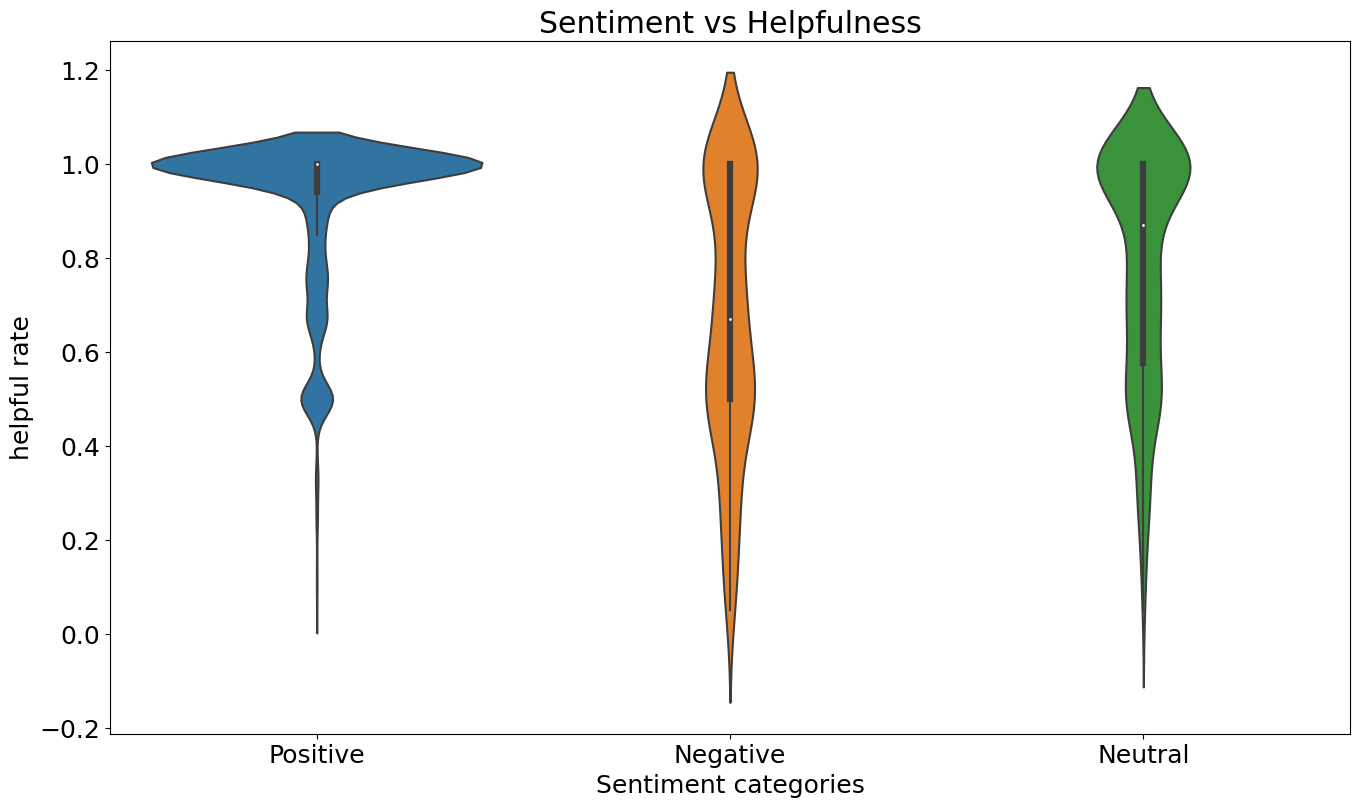

In [21]:
#plot layout
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

# Creating dataframe and removing 0 helpfulrate records
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["sentiment"], y=senti_help["helpful_rate"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

Year vs Sentiment count - wrong

In [22]:
process_reviews.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

Day of month vs Reviews count - wrong

In [32]:
#Creating a dataframe
day=pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day']=day['day'].astype('int64')
day.sort_values(by=['day'])

#Plotting the graph
#sns.barplot(x="day", y="reviews", data=day)
sns.barplot(x="day", y="reviews", data=day, color='lightblue')
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()

Wordcloud

word cloud of positive reviews

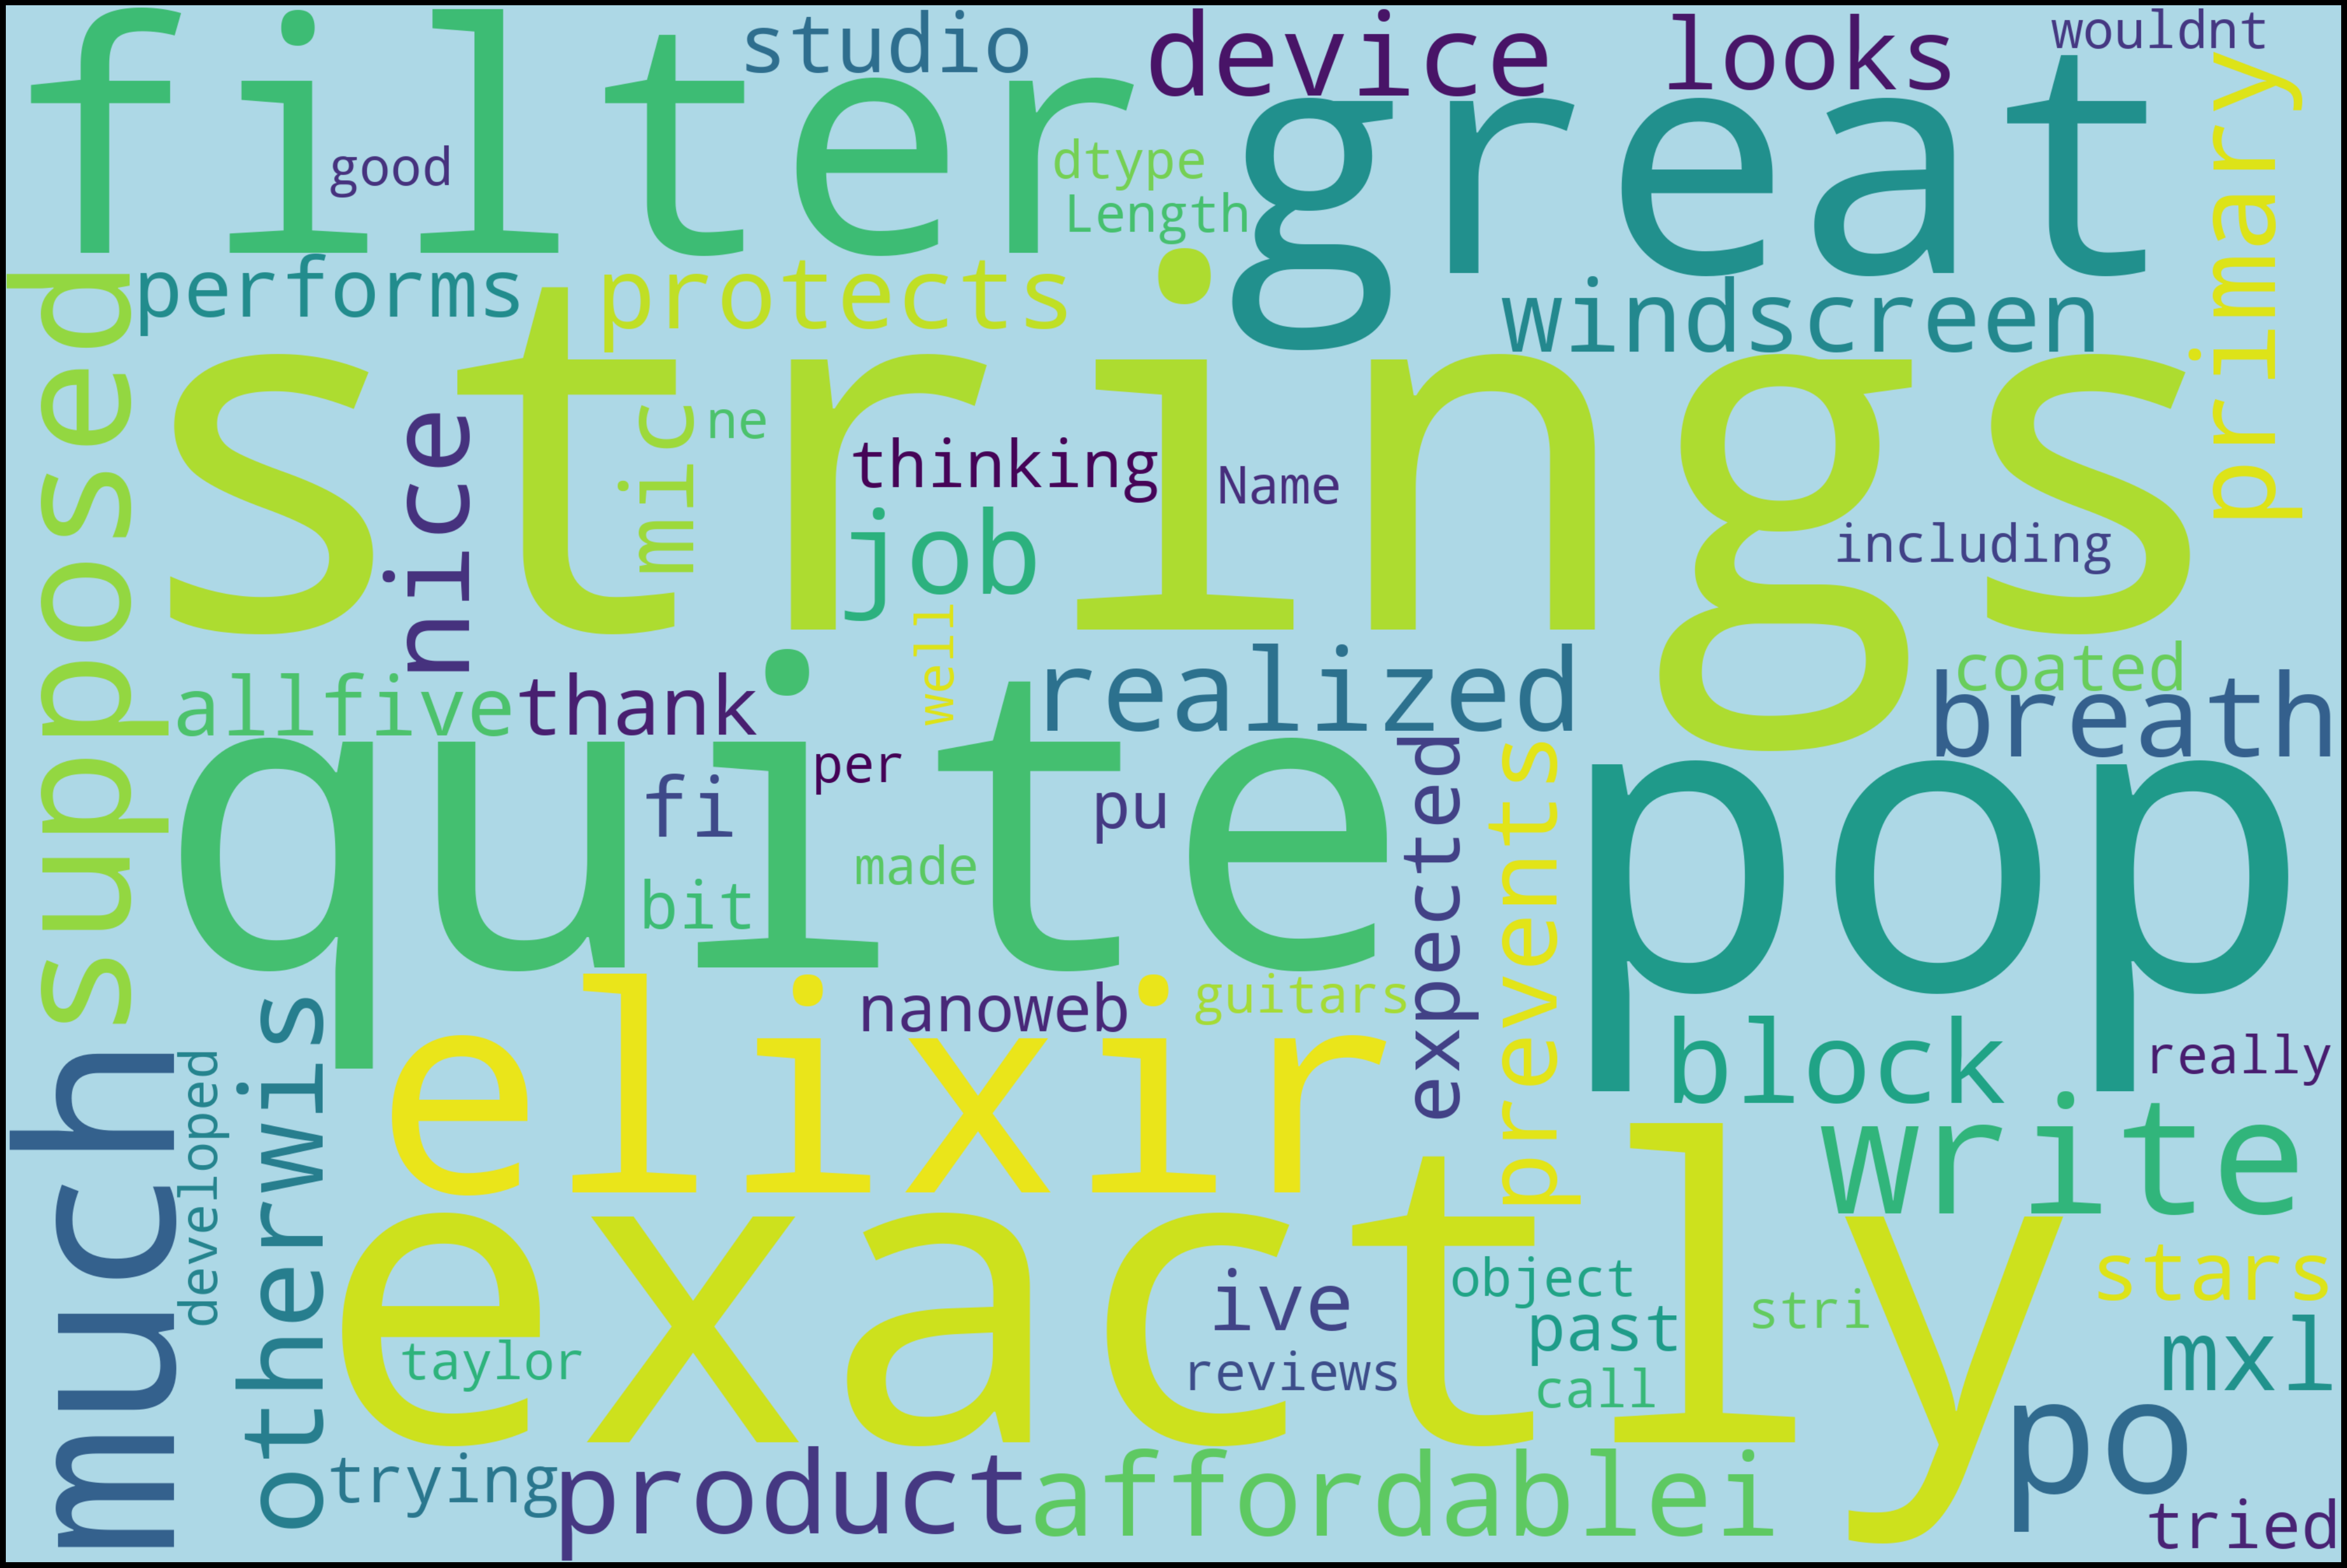

In [33]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'lightblue',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

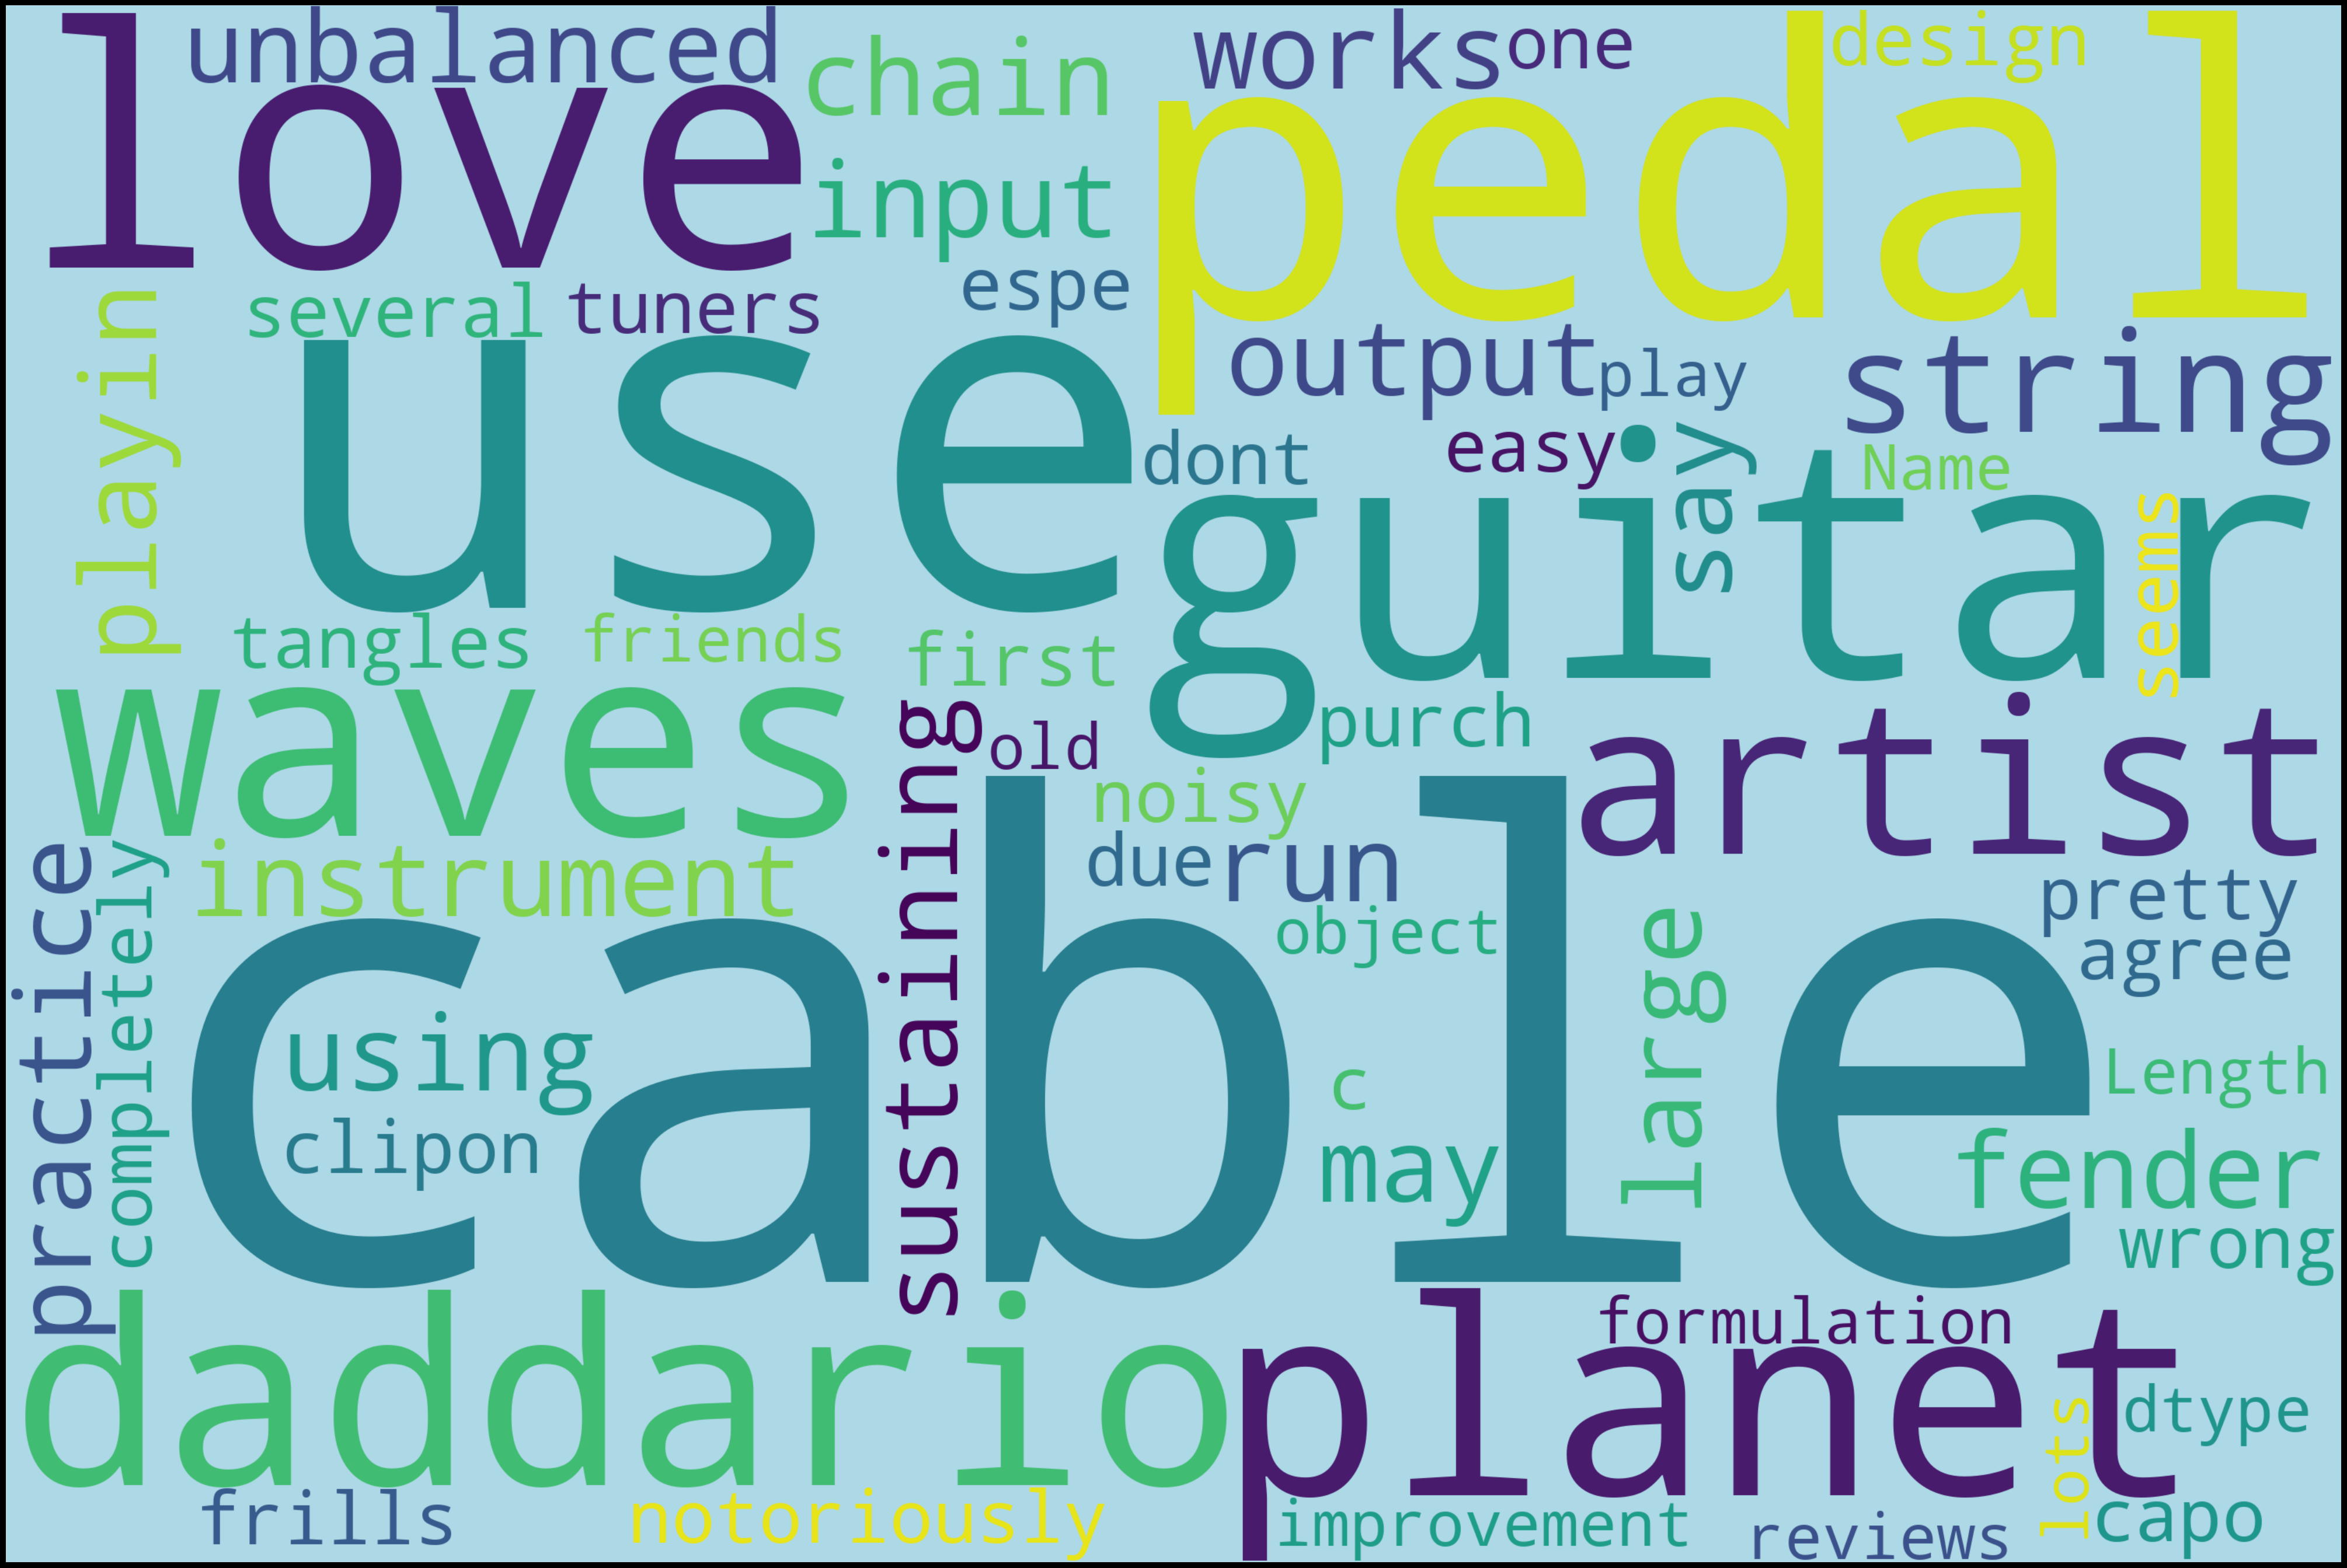

In [40]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'lightblue',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

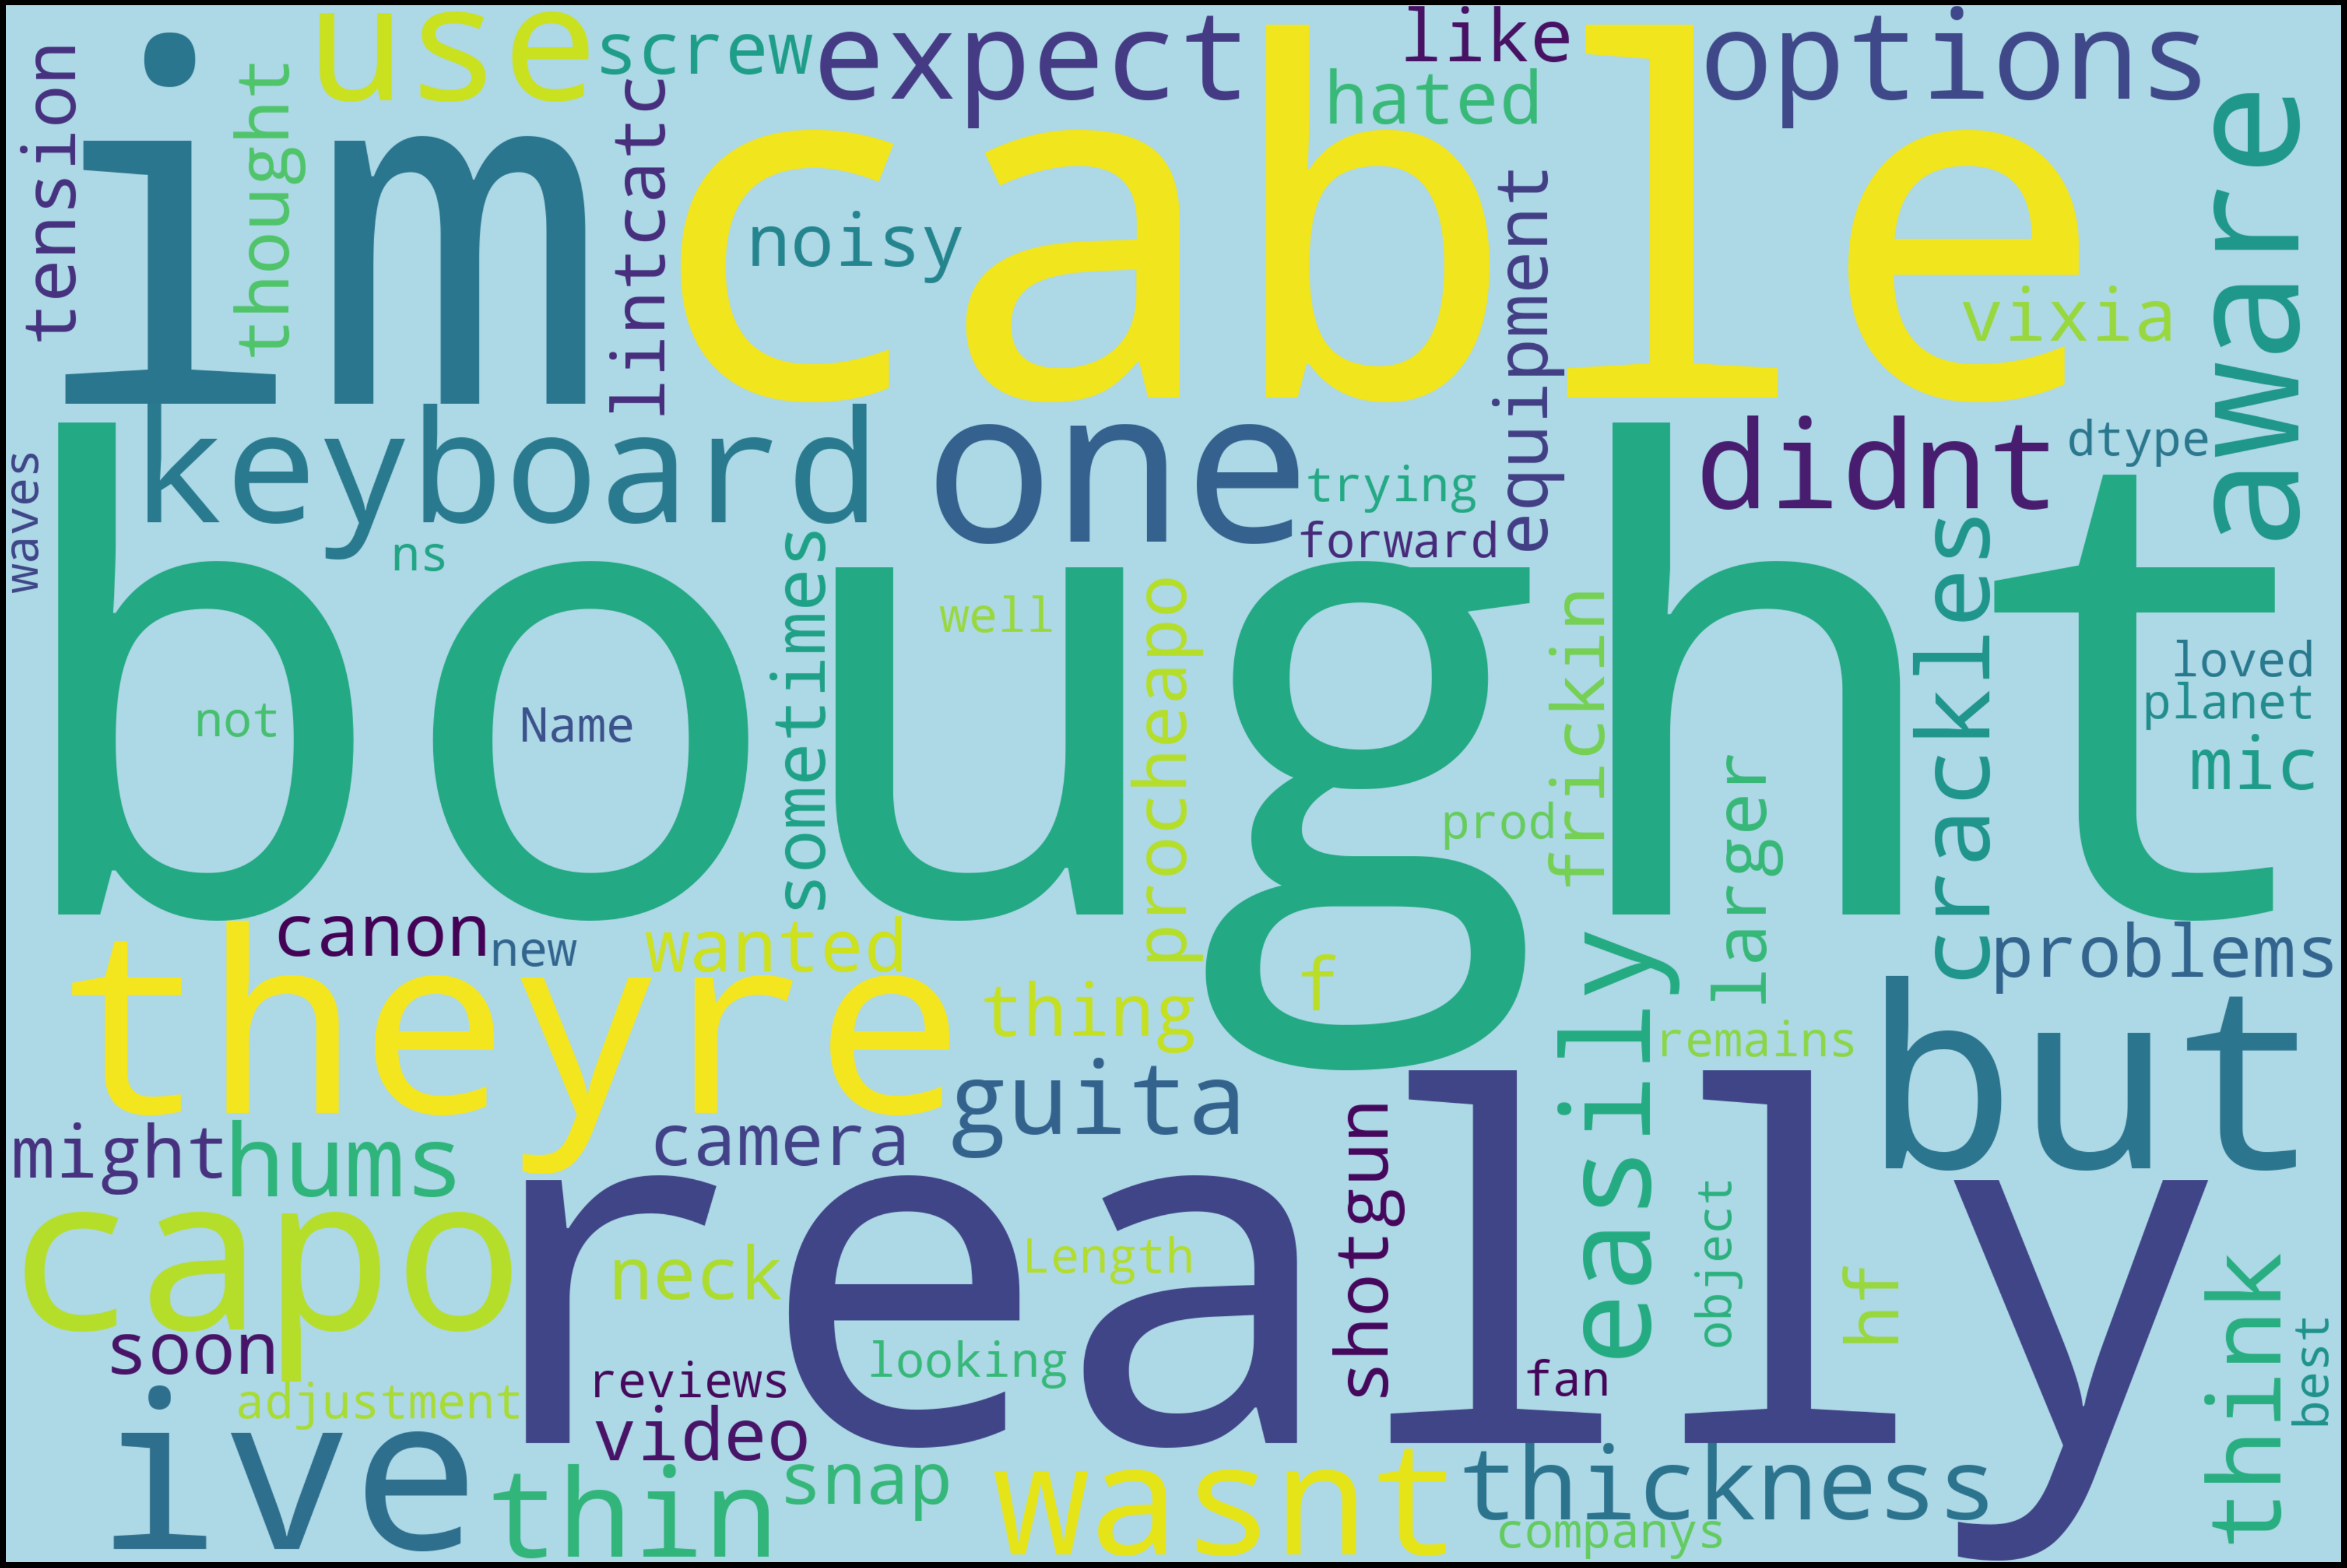

In [39]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'lightblue',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()